Load dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

path = './data/dataset.csv'

df = pd.read_csv(path, index_col=0)
display(df.head())

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Plotting various columns vs popularity

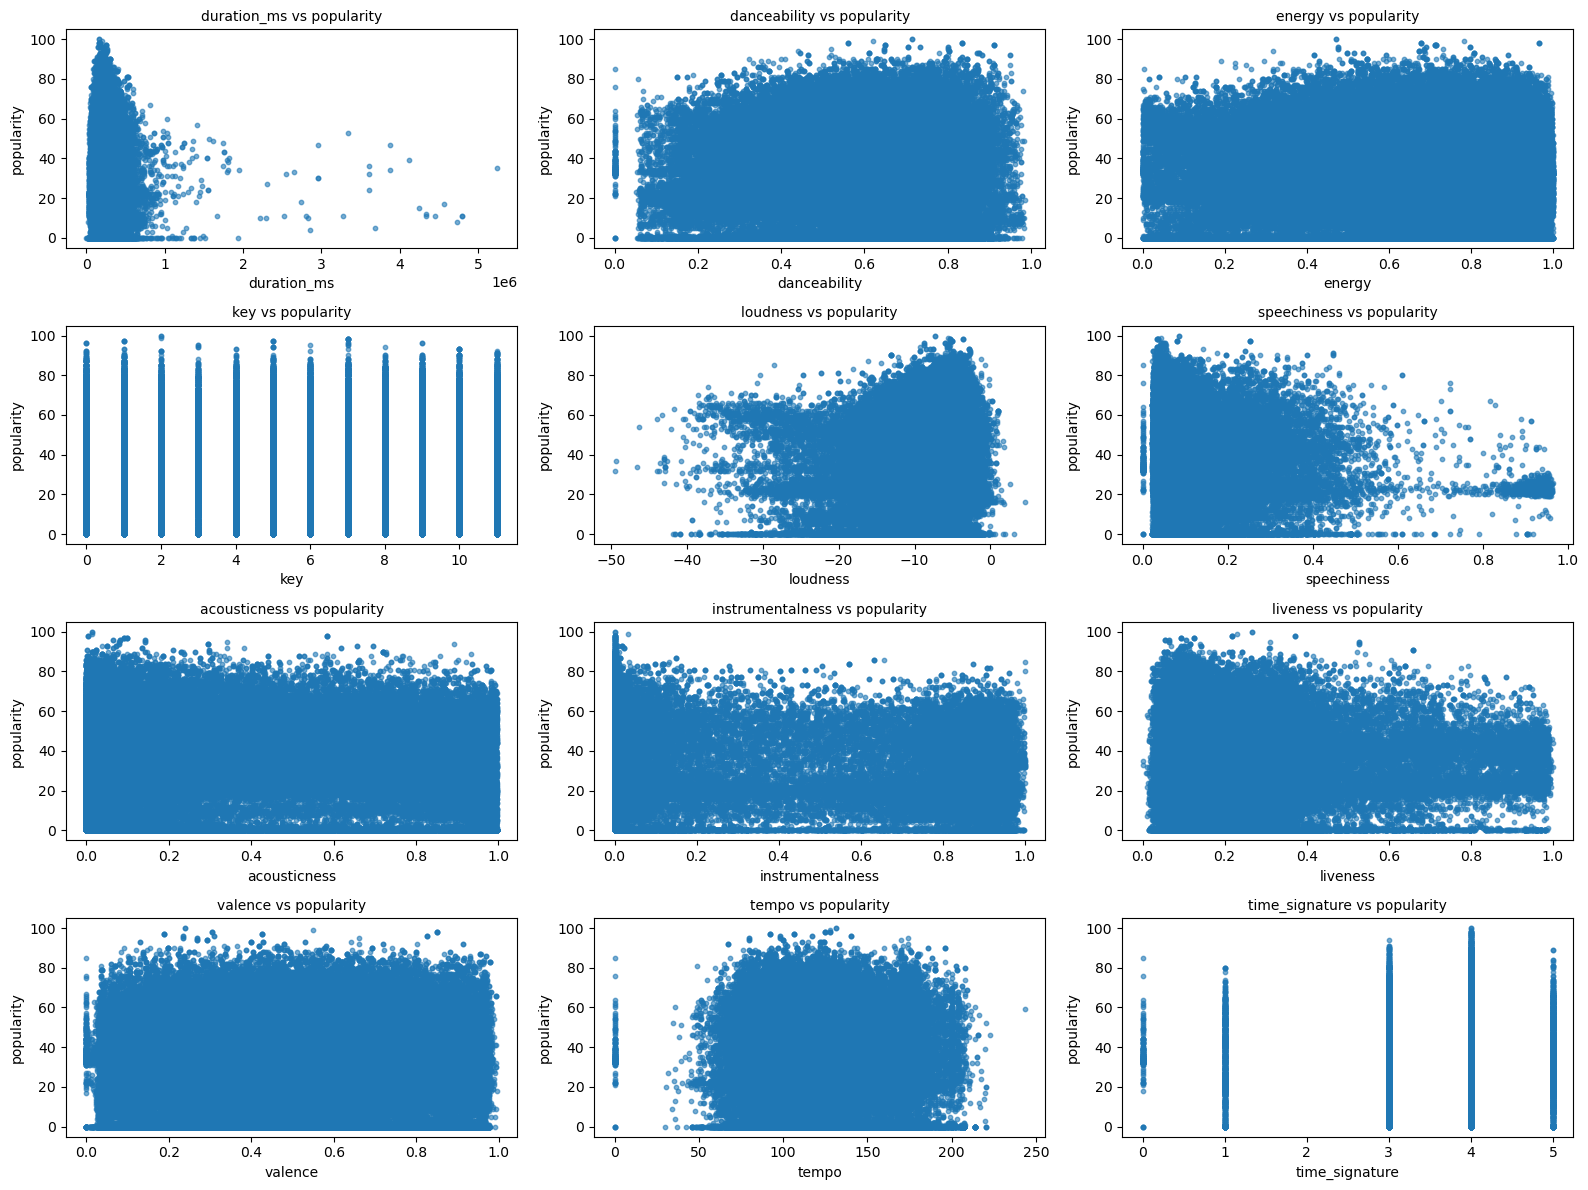

In [ ]:
columns = ["duration_ms", "danceability", "energy", "key", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]
target = "popularity"
fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(columns):
  ax = axes[i]
  ax.scatter(df[col], df[target], alpha=0.6, s=10)
  ax.set_title(col + " vs " + target, fontsize=10)
  ax.set_xlabel(col)
  ax.set_ylabel(target)
plt.tight_layout()
plt.show()


TODO: data cleanup/ better plotting